# Manning Publications: Data Science Bookcamp
## Case Study 3: Tracking Disease Outbreaks Using News Headlines¶
### Part 4: identifying disease outbreaks
                                                2020 Jamie Shaffer

### Objective

Identify pandemics by analyzing the centrally located headlines in the largest clusters of headlines. Look at the prevalence of disease in each cluster. Any disease outbreaks in the United States or around the world will be reported back to superiors at the WHO to direct help where it’s needed.

### Workflow

1. Separate the data into world and US datasets.
 - This can be done using the countrycode for each city from geonamescache.
1. Re-cluster the world and US data separately.
 - This may require different clustering parameters for each dataset.
 - Put your code into functions to quickly cluster and visualize results of the model.
1. Sort the clusters by the number of headlines from largest to smallest.
1. Sort headlines within each cluster by finding headlines closest to the center of the cluster.
 - You can average the location coordinates in each cluster to get an approximation of the center. If you want to be more accurate, then you’ll need to apply a geographic formula to find the true geographic center of each cluster.
1. Examine the headlines closest to the center of each cluster. Record any repeated diseases in the headlines. Do this for both the US and the world data.
 - If no diseases appear to be repeating, try the clustering again. Also make sure to look at enough headlines within each cluster to find repeated diseases.
1. Pinpoint disease outbreaks based on repeated diseases within headlines in clusters. Prepare final maps of the United States and the world.
 - If you find one or two major diseases, you can find all mentions of it in headlines using regular expressions.
 - Remove any irrelevant headlines from the map for presentation.

## IMPORTS

In [1]:
import re                         # 2.2.1
import numpy as np
import pandas as pd               # 0.25.0
import geonamescache              # 1.1.0
#import unidecode                 # has no __version__
from unidecode import unidecode

# PEP 484 type hints are easier with this
from typing import Tuple

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
%matplotlib inline

from pylab import rcParams

# from sklearn.cluster import KMeans  # not yet decided if we'll try this
from sklearn.cluster import DBSCAN

for library in [re,pd,geonamescache]:
    libname = (str(library)).split()[1]
    print(libname," version is ",library.__version__)

're'  version is  2.2.1
'pandas'  version is  0.25.0
'geonamescache'  version is  1.1.0


## GLOBALS

In [2]:
## GLOBALS

GLOBAL_FILL_STRING = 'not_specified'

# For debugging, set this to 1
debug = 0

# Headlines with cities are in this file:
fname1= r"C:\Users\jshaf\GitHub\data-science-portfolio\projects"
#fname2 = r"\manning-data-science-bookcamp\jupyter_notebooks\s3_headline_clusters.csv"
fname2 = r"\discovering-disease-outbreaks\jupyter-notebooks\s3_headline_clusters_gc.csv"
fname = fname1 + fname2

fname = r"../data-files/s3_headline_clusters_gc.csv"


rcParams['figure.figsize']=12,5   # set it once and for all!

In [3]:
fname

'../data-files/s3_headline_clusters_gc.csv'

In [4]:
# disease dictionary list
#   key (term to search for) : value (term to use when classifying)
#
# TODO: mad cow in humans is variant Creutzfeldt-Jakob disease (vCJD)

disease_dictionary = {'aids':'aids',
                'bronchitis' :'bronchitis',
                'cancer'     :'cancer',
                'chickenpox' :'varicella',
                'chikungunya':'chikungunya',
                'chik fever' :'chikungunya',
                'chlamydia'  :'chlamydia',
                'cholera'    :'cholera',
                'dengue'     :'dengue',
                'ebola'      :'ebola',
                'flu'        :'influenza',
                'gonorrhea'  :'gonorrhea',   
                'hepatitis A':'hepatitis A',
                'hepatitis B':'hepatitis B',
                'hepatitis C':'hepatitis C',
                'hepatitis D':'hepatitis D',
                'hepatitis E':'hepatitis E',
                'herpes'     :'herpes',
                'hiv'        :'hiv',
                'influenza'  :'influenza',
                'mad cow'    :'mad cow',
                'malaria'    :'malaria',
                'measles'    :'measles',
                'meningitis' :'meningitis',
                'mumps'      :'mumps',
                'norovirus'  :'norovirus',
                'pneumonia'  :'pneumonia',
                'Respiratory Syncytial Virus':'RSV',
                'rabies'     :'rabies',
                'rotavirus'  :'rotavirus',
                'rhinovirus' :'rhinovirus',
                'syphilis'   :'syphilis',
                'tuberculosis':'tuberculosis',
                'varicella'  :'varicella',
                'vericella'  :'varicella',                      
                'west nile'  :'west nile',
                'zika'       :'zika'}

## FUNCTIONS

In [5]:
# https://stackoverflow.com/questions/17411940/matplotlib-scatter-plot-legend
# Handy way to build the legend
def get_legend_markers(D_label_color, marker="o", marker_kws={"linestyle":""}):
    """
    Usage: plt.legend(*legend_vars(D_taxon_color),
                      loc="lower center",
                      bbox_to_anchor=(0.5,-0.15),
                      fancybox=True, shadow=True,
                      prop={'size':15})

    Input: Dictionary object of {label:color}
    Output: Tuple of markers and labels
    """
    # Any marker you want to have in the legend must be put on the plot; this makes sure 
    # that it's on there.
    markers = [plt.Line2D([0,0],[0,0],color=color, marker=marker,\
                          **marker_kws) for color in D_label_color.values()]
    return (markers, D_label_color.keys())

In [6]:
def find_disease(in_str:str)->str:
    '''Returns the disease group of the alphabetically first disease detected in the string
       Examples:
          Are Zika and AIDS still a concern in Mexico?   -> returns AIDS
          Call it chicken pox or varicella -- it's still on the rise!   -> returns varicella
              because the dictionary maps both to an output group of varicella
       INPUT: string e.g. a headline
       OUTPUT: name of disease
    '''
    
    # default return if nothing found; disease_list may be incomplete
    found = 'no_disease_found'    

    
    for k,v in disease_dictionary.items():
        uni_search = r'\b' + k + r'\b'
        regexp = re.compile(uni_search,flags=re.IGNORECASE)
        
        if (regexp.search(in_str)):
            found = v
            break
            
    return found


In [7]:
def draw_cluster_map(df_in:pd.DataFrame,cluster_column:str,title:str,\
                    show_states=False, show_rivers=False,set_res='c',spot_size=50,\
                    ax=None):
    '''Takes in a dataframe that has the columns latitude, longitude, DBSCAN_cluster and
       draws the clusters on a map
       INPUTS: 
           dataframe          pandas dataframe
           cluster_column     Name of the column containing the cluster integer
           title              Title to print on the map
           show_states        Draw the outlines of US states
           show_rivers        Draw rivers (useful for waterborne diseases)
           set_res            Set the resolution to c=crude, l=low, i=intermediate, h=high, f=full
    '''
    # setting up the zoom -- here's the whole world
    m_llcrnrlon = -180
    m_llcrnrlat = -90
    m_urcrnrlon = 180
    m_urcrnrlat = 90   
    
    # try calculating zoom
    if (1):
        border = 5.0
        m_llcrnrlat = df_in['latitude'].min() - border
        m_urcrnrlat = df_in['latitude'].max() + border
        m_llcrnrlon = df_in['longitude'].min() - border
        m_urcrnrlon = df_in['longitude'].max() + border
        
    # started with 'cyl'
    # try 'mill' for miller and add resolution
    
    if (ax == None):
        ax = plt.gca()
        
    map_plotter = Basemap(projection='cyl',\
                                     llcrnrlon = m_llcrnrlon,\
                                     llcrnrlat = m_llcrnrlat,\
                                     urcrnrlon = m_urcrnrlon,\
                                     urcrnrlat = m_urcrnrlat,\
                                     ax=ax,\
                                     resolution=set_res)  
        
    cc1 = df_in[cluster_column].unique()
    cc2 = np.sort(cc1, axis=-1, kind='quicksort', order=None)
    cc2
    # Working out colors and legend match-up
    color_order =['blue', 'cyan', 'magenta',\
                  'yellow','coral', 'purple', 'teal', 'pink', 'brown', 'black',\
                  'orange', 'red', 'lightblue', 'lime', \
                  'lavender', 'turquoise', 'darkgreen', 'tan', 'salmon', \
                  'gold', 'plum', 'olive', 'burlywood', 'darkorange',\
                  'peru', 'tomato', 'saddlebrown', 'cadetblue', 'thistle',\
                  'forestgreen', 'darkkhaki', 'green', 'royalblue']
    

    D_label_color = {}
    
    #plt.figure(figsize=(20, 20))
    
    map_plotter.drawcoastlines()
    map_plotter.drawcountries()
    map_plotter.shadedrelief()
    if (show_states):
        map_plotter.drawstates()
    if (show_rivers):
        map_plotter.drawrivers()
    

#    for c in range(-1,len(cc2)-1):
    for c in cc2:
        mini_df = df_in[df_in[cluster_column]==c]
        lat_list = mini_df['latitude']
        lon_list = mini_df['longitude']
        if (c == -1):  
            map_plotter.scatter(lon_list,lat_list,latlon=True, c='red', marker = 'x',s=spot_size)
            D_label_color["Isolate"] = 'red'
        else:
            map_plotter.scatter(lon_list,lat_list,latlon=True, c=color_order[c],s=spot_size)
            str_cluster = "Cluster " + str(c)
            D_label_color[str_cluster]=color_order[c]

    #ax = plt.gca()    

    #plt.title(title)
    ax.set_title(title)
    ax.legend(*get_legend_markers(D_label_color),bbox_to_anchor=(0, 0, 1.09, 1)) 
    ##bbox_to_anchor=(0, 0, 1.09, 1)) -- puts it on the right
    ##bbox_to_anchor=(0, 0, .096, .32)) -- puts it in lower left, but may cover data
    return map_plotter

In [8]:
# Code copied and modified from the live module section 4.2:

from math import cos, sin, asin, pi

earth_distance = 12428.14

def great_circle_distance(x1, y1, x2, y2):
    delta_x, delta_y = x2 - x1, y2 - y2
    haversin = sin(delta_x / 2) ** 2 + np.product([cos(x1), cos(x2),
                                                   sin(delta_y / 2) ** 2])
    return 2 * asin(haversin ** 0.5)

# Copied out of the solutions for section 3 and modified slightly 
def great_circle_distance_metric(coord1:np.ndarray, coord2:np.ndarray, radius=3956)->float:
    """
    Calculates the great circle distance between two coordinates or arrays of coordinates. The input format
    is set up to work as a metric for a DBSCAN clustering.
    INPUT:
        coord1: np.array of 2 coords
        coord2: np.array of 2 coords
    OUTPUT:
        distance in miles over the surface of a spherical earth : float
    """

    if np.array_equal(coord1, coord2):
        return 0.0

    # Convert lat/lon to radians
    coord1, coord2 = np.radians(coord1), np.radians(coord2)
    # Find the difference between the coordinates
    delta_x, delta_y = coord2 - coord1
    
    # Apply Haversin formula
    haversin = np.sin(delta_x / 2) ** 2 + np.product(
        [np.cos(coord1[0]), np.cos(coord2[0]), np.sin(delta_y / 2) ** 2]
    )

    # Convert to distance in miles
    return 2 * radius * np.arcsin(haversin ** 0.5)


def travel_distance(lat1, lon1, lat2, lon2):
    '''Takes in lat,lon for 2 points and returns the great circle distance in miles'''
    to_radians =  np.radians([lat1, lon1, lat2, lon2])
    tdist = round(3956 * great_circle_distance(*to_radians.tolist()),1)
    #return 3956 * great_circle_distance(*to_radians.tolist())
    #print("tdist is {} which could be rounded to {}".format(tdist,round(tdist,1)))
    return tdist

travel_distance(90, 0, -90, 0)
#assert travel_distance(90, 0, -90, 0) == earth_distance

12428.1

In [9]:
def find_dist_to_centroid(row,colname,verbose=False):

    # US, or non US? This determines whether we use the -e or -gc clustering and which cluster_mid dictionary
    if (row['country'] == 'US'):
        lat_mid, lon_mid = cluster_mids_US[row[colname]]
    else:
        if (verbose):
            print("WORLD looking to figure out row\n\t {}".format(row))
        lat_mid, lon_mid = cluster_mids_WORLD[row[colname]]
        
    dist = travel_distance(row['latitude'], row['longitude'],lat_mid,lon_mid)
    #print("cluster {} dist {} row['latitude'] is {}".format(row[colname],dist,row['latitude']))
    return dist

In [10]:
def create_cluster_midpoint_dictionary(df_in,colname,verbose = False):
    cluster_dict = {}
    
    cc1 = df_in[colname].unique()
    cc2 = np.sort(cc1, axis=-1, kind='quicksort', order=None)
    cc2    

    for c in range(-1,len(cc2)-1):
        mini_df = df_in[df_in[colname]==c]
        lat_mid = mini_df['latitude'].mean()
        lon_mid = mini_df['longitude'].mean()
        if (verbose):
            print("cluster {} has midpoint at {},{}".format(c,lat_mid,lon_mid))
        cluster_dict[c] = [lat_mid,lon_mid]
    if (verbose):
        print("Cluster dict: \n {}".format(cluster_dict))
    
    return cluster_dict

## MAIN

In [11]:
df = pd.read_csv(fname)
df.head(n=3)

,Unnamed: 0,headline,city,country,latitude,longitude,cityduplicates,countrycode,DBSCAN_cluster_e,DBSCAN_cluster_gc
0,0,Pedro Juan Caballero Encounters Severe Symptom...,Pedro Juan Caballero,NaN,-22.54722,-55.73333,1,PY,0,-1
1,1,Rumors about Hepatitis D Spreading in San Juan...,San Juan Capistrano,NaN,33.50169,-117.66255,1,US,1,0
2,2,Zika Spreads to Palm Beach Gardens,Palm Beach Gardens,NaN,26.82339,-80.13865,1,US,1,1


### Step 0: Create a feature for the reported disease

In [12]:
find_disease('zika troubles country')

'zika'

In [13]:
df['disease'] = df['headline'].apply(lambda x: find_disease(x))

In [14]:
# TODO: flag headlines that are about preventive or other measures, 
# e.g. contain the word "vaccine"

In [15]:
# what's missing
df[df['disease'] == 'no_disease_found'].tail(n=3)

,Unnamed: 0,headline,city,country,latitude,longitude,cityduplicates,countrycode,DBSCAN_cluster_e,DBSCAN_cluster_gc,disease
583,583,Doral hit by Deadly Virus,Doral,NaN,25.81954,-80.35533,1,US,1,1,no_disease_found
586,586,Scientists in Paris to look for answers,Paris,NaN,48.85341,2.34880,2,FR,3,-1,no_disease_found
608,608,Contaminated Meat Brings Trouble for Bonn Farmers,Bonn,NaN,50.73438,7.09549,1,DE,3,7,no_disease_found


### Step 1: Split into US and WORLD datasets

In [16]:
df_US = df[df['countrycode'] == 'US'].copy()
df_US['countrycode'].value_counts()

US    307
Name: countrycode, dtype: int64

In [17]:
df_WORLD = df[df['countrycode'] != 'US'].copy()
df_WORLD['countrycode'].nunique()

93

### Step 2: Re-cluster the world and US data separately.

### World clusters

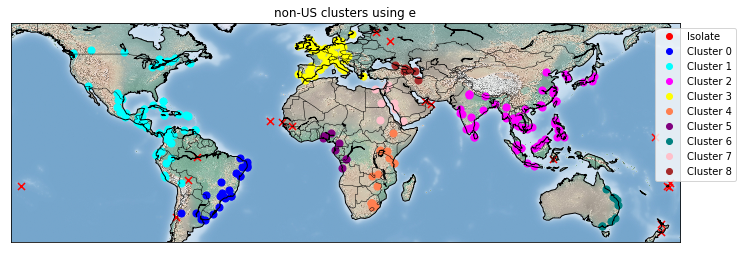

In [18]:
# Use the clusters that come in with the new s3_*_gc
m = draw_cluster_map(df_WORLD,'DBSCAN_cluster_e','non-US clusters using e')

### US clusters

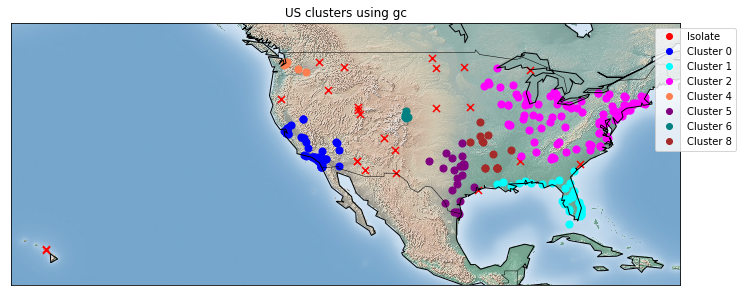

In [19]:
# Use the clusters that come in with the new s3_*_gc
m = draw_cluster_map(df_US,'DBSCAN_cluster_gc','US clusters using gc')

### Step 3: Sort the clusters by the number of headlines from largest to smallest

In [20]:
# How many headlines in each cluster? Note that these are clusters formed using Great Circle distances.
df_US['DBSCAN_cluster_gc'].value_counts()

 2    128
 0     55
 1     49
-1     24
 5     24
 8     14
 6      7
 4      6
Name: DBSCAN_cluster_gc, dtype: int64

In [21]:
# How many headlines in each cluster? Note that these are clusters formed with Euclidean distances.
df_WORLD['DBSCAN_cluster_e'].value_counts()

 2    78
 1    70
 3    62
 0    27
-1    18
 4    15
 6     9
 5     9
 7     8
 8     6
Name: DBSCAN_cluster_e, dtype: int64

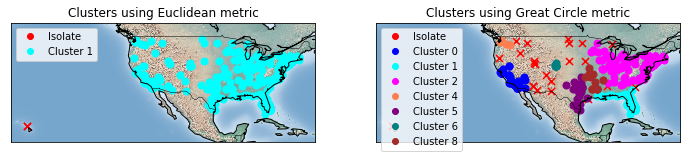

In [22]:
# Explore placing maps side by side to compare clustering methods
# https://basemaptutorial.readthedocs.io/en/latest/subplots.html

fig, axes = plt.subplots(1,2)

#axes[0].set_title("Euclidean")
m = draw_cluster_map(df_US,'DBSCAN_cluster_e','Clusters using Euclidean metric',ax=axes[0])

#axes[1].set_title("Great Circle")
m = draw_cluster_map(df_US,'DBSCAN_cluster_gc','Clusters using Great Circle metric',ax=axes[1])

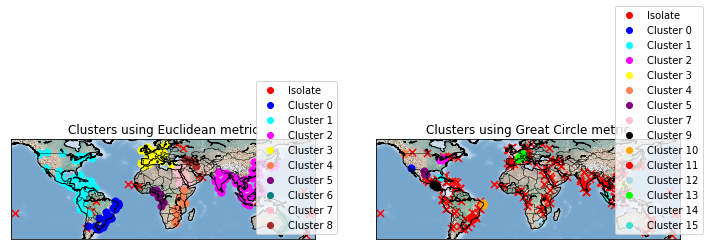

In [23]:
# Explore placing maps side by side to compare clustering methods
# https://basemaptutorial.readthedocs.io/en/latest/subplots.html

fig, axes = plt.subplots(1,2)

#axes[0].set_title("Euclidean")
m = draw_cluster_map(df_WORLD,'DBSCAN_cluster_e','Clusters using Euclidean metric',ax=axes[0])

#axes[1].set_title("Great Circle")
m = draw_cluster_map(df_WORLD,'DBSCAN_cluster_gc','Clusters using Great Circle metric',ax=axes[1])

### Step 4: Sort headlines within each cluster by finding headlines closest to the center of the cluster

In [24]:
df_US.head(n=2)  #check the columns

,Unnamed: 0,headline,city,country,latitude,longitude,cityduplicates,countrycode,DBSCAN_cluster_e,DBSCAN_cluster_gc,disease
1,1,Rumors about Hepatitis D Spreading in San Juan...,San Juan Capistrano,NaN,33.50169,-117.66255,1,US,1,0,hepatitis D
2,2,Zika Spreads to Palm Beach Gardens,Palm Beach Gardens,NaN,26.82339,-80.13865,1,US,1,1,zika


In [25]:
cluster_mids_US = create_cluster_midpoint_dictionary(df_US,'DBSCAN_cluster_gc')

In [26]:
cluster_mids_WORLD = create_cluster_midpoint_dictionary(df_WORLD,'DBSCAN_cluster_e',False)

In [27]:
df_US['headline_dist'] = df_US.apply(lambda row: find_dist_to_centroid(row,'DBSCAN_cluster_gc'), axis=1)

In [28]:
df_WORLD['headline_dist'] = df_WORLD.apply(lambda row: find_dist_to_centroid(row,'DBSCAN_cluster_e'), axis=1)

### Step 5: Examine the headlines closest to the center of each cluster. Record any repeated diseases in the headlines. Do this for both the US and the world data.

In [29]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_US.groupby(['DBSCAN_cluster_gc'])['disease'].value_counts())

DBSCAN_cluster_gc  disease         
-1                 rotavirus            3
                   measles              2
                   pneumonia            2
                   zika                 2
                   RSV                  1
                   chikungunya          1
                   chlamydia            1
                   gonorrhea            1
                   hepatitis A          1
                   hepatitis D          1
                   hepatitis E          1
                   hiv                  1
                   influenza            1
                   malaria              1
                   meningitis           1
                   rhinovirus           1
                   syphilis             1
                   tuberculosis         1
                   varicella            1
 0                 zika                10
                   varicella            6
                   influenza            4
                   west nile            

In [30]:
us_headlines = df_US.groupby(['DBSCAN_cluster_gc','headline_dist'])['disease'].value_counts()
# use pd.option_context to set display options so that we can see all the rows and columns
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    print(us_headlines)

DBSCAN_cluster_gc  headline_dist  disease         
-1                 1395.1         hiv                 1
                   1403.9         measles             1
                   1984.6         influenza           1
                   2154.2         zika                1
                   2186.2         chikungunya         1
                   2241.2         meningitis          1
                   2270.9         syphilis            1
                   2271.0         rotavirus           1
                   2274.3         pneumonia           1
                   2383.9         tuberculosis        1
                   2497.3         chlamydia           1
                   2734.7         pneumonia           1
                   2775.8         RSV                 1
                   2800.8         rotavirus           1
                   2807.7         gonorrhea           1
                   2810.0         rotavirus           1
                   2883.9         rhinovirus         

In [31]:
df_US_view = df_US.loc[:,['DBSCAN_cluster_gc','headline_dist','disease','headline']]

In [32]:
df_US_view.sort_values(['DBSCAN_cluster_gc', 'headline_dist'], ascending=[True, True])

,DBSCAN_cluster_gc,headline_dist,disease,headline
555,-1,1395.1,hiv,New medicine wipes out HIV in Kihei
393,-1,1403.9,measles,Measles Vaccine is now Required in Wailuku
234,-1,1984.6,influenza,"Flu outbreak in Galveston, Texas"
389,-1,2154.2,zika,El Paso fighting Zika
448,-1,2186.2,chikungunya,New medicine wipes out Chikungunya in Tucson
102,-1,2241.2,meningitis,Meningitis re-emerges in Summerville
362,-1,2270.9,syphilis,Phoenix Residents Recieve Syphilis vaccine
160,-1,2271.0,rotavirus,Rotavirus Vaccine is now Required in Starkville
289,-1,2274.3,pneumonia,Pneumonia Exposure in Alhambra
104,-1,2383.9,tuberculosis,Spike of Tuberculosis Cases in Albuquerque


In [33]:
# By inspection, US clusters have
# 0,1,2,5 -- zika
mask_zika = df_US['disease'] == 'zika'
mask_cluster = (df_US['DBSCAN_cluster_gc'] == 0) | (df_US['DBSCAN_cluster_gc'] == 1) | \
                 (df_US['DBSCAN_cluster_gc'] == 2) | (df_US['DBSCAN_cluster_gc'] == 5)

df_US_zika = df_US[mask_zika]

df_US_cluster_zika = df_US[mask_cluster & mask_zika]
df_US_cluster_zika[['DBSCAN_cluster_gc','disease','headline','city']].head(n=15)

,DBSCAN_cluster_gc,disease,headline,city
2,1,zika,Zika Spreads to Palm Beach Gardens,Palm Beach Gardens
3,1,zika,Zika Reported in North Miami Beach,North Miami Beach
7,1,zika,Hallandale Beach a Victim of Zika Outbreak,Hallandale Beach
11,1,zika,Zika arrives in West Palm Beach,West Palm Beach
12,1,zika,Spring break ruined by Zika in Fort Lauderdale,Fort Lauderdale
15,5,zika,Outbreak of Zika in Corpus Christi,Corpus Christi
19,1,zika,Zika Strikes St. Petersburg,St. Petersburg
20,1,zika,Zika symptoms spotted in Bonita Springs,Bonita Springs
27,0,zika,Zika Virus Reaches San Francisco,San Francisco
28,1,zika,Zika symptoms spotted in Boynton Beach,Boynton Beach


Looking through the top headlines, it's clear that some of these are reporting cases but others are just 
wondering about the future, suggesting actions to take, or reporting news from elsewhere. Natural language 
processing would help sort through these.

Last US step -- plot zika in clusters AND zika anywhere, just in case our clustering was poor

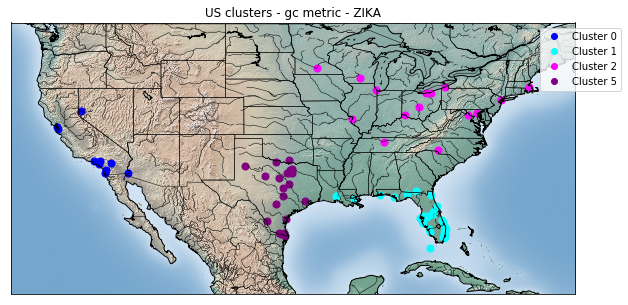

In [34]:
m = draw_cluster_map(df_US_cluster_zika,'DBSCAN_cluster_gc','US clusters - gc metric - ZIKA',True,True,'l')

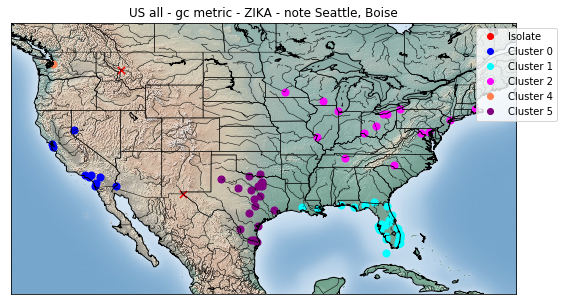

In [35]:
m = draw_cluster_map(df_US_zika,'DBSCAN_cluster_gc','US all - gc metric - ZIKA - note Seattle, Boise',True,True,'l')

In [36]:
world_headlines = df_WORLD.groupby('DBSCAN_cluster_e')['disease'].value_counts()
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    # there are more options that can be specified also
    print(world_headlines)

DBSCAN_cluster_e  disease         
-1                zika                 4
                  rotavirus            2
                  cancer               1
                  chlamydia            1
                  cholera              1
                  hepatitis C          1
                  hepatitis D          1
                  hiv                  1
                  influenza            1
                  measles              1
                  norovirus            1
                  pneumonia            1
                  varicella            1
                  west nile            1
 0                zika                21
                  no_disease_found     2
                  bronchitis           1
                  norovirus            1
                  pneumonia            1
                  rotavirus            1
 1                zika                41
                  meningitis           3
                  dengue               2
                  hepa

In [37]:
# By inspection, the WORLD has 
# possible zika outbreaks in regions 0, 1, 2 
# possible mad cow outbreak in 3

mask_zika = df_WORLD['disease'] == 'zika'
mask_madcow = df_WORLD['disease'] == 'mad cow'
mask_cluster012 = (df_WORLD['DBSCAN_cluster_e'] == 0) | (df_WORLD['DBSCAN_cluster_e'] == 1) | \
                 (df_WORLD['DBSCAN_cluster_e'] == 2)
mask_cluster3 = (df_WORLD['DBSCAN_cluster_e'] == 3)

df_WORLD_zika = df_WORLD[mask_zika]
df_WORLD_madcow = df_WORLD[mask_madcow]

df_WORLD_cluster_zika = df_WORLD[mask_cluster012 & mask_zika]
df_WORLD_cluster_zika[['DBSCAN_cluster_e','disease','headline','city']].head(n=15)

df_WORLD_cluster_madcow = df_WORLD[mask_cluster3 & mask_madcow]

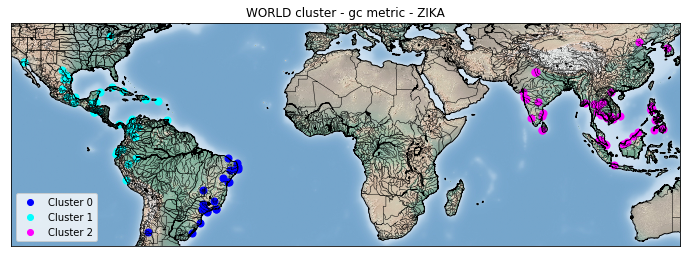

In [38]:
m = draw_cluster_map(df_WORLD_cluster_zika,'DBSCAN_cluster_e','WORLD cluster - gc metric - ZIKA',True,True,'l')

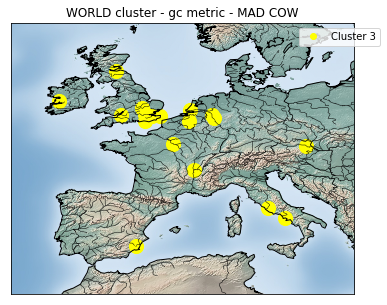

In [39]:
m = draw_cluster_map(df_WORLD_madcow,'DBSCAN_cluster_e','WORLD cluster - gc metric - MAD COW',True,True,'l',200)

In [40]:
df_WORLD_madcow

,Unnamed: 0,headline,city,country,latitude,longitude,cityduplicates,countrycode,DBSCAN_cluster_e,DBSCAN_cluster_gc,disease,headline_dist
43,43,More Livestock in Fontainebleau are infected w...,Fontainebleau,NaN,48.40908,2.70177,1,FR,3,-1,mad cow,16.7
206,206,Mad Cow Disease Hits Rotterdam,Rotterdam,NaN,51.92250,4.47917,2,NL,3,7,mad cow,259.3
243,243,Authorities are Worried about the Spread of Ma...,Edinburgh,NaN,55.95206,-3.19648,1,GB,3,-1,mad cow,537.5
264,264,Rumors about Mad Cow Disease Brighton have bee...,Brighton,NaN,50.82838,-0.13947,4,GB,3,7,mad cow,183.8
292,292,Duisburg up in Arms over Mad Cow Disease,Duisburg,NaN,51.43247,6.76516,1,DE,3,7,mad cow,225.5
345,345,Mad Cow Disease Disastrous to Brussels,Brussels,NaN,50.85045,4.34878,1,BE,3,7,mad cow,185.3
363,363,Will Mad Cow Vaccine Help Bristol?,Bristol,NaN,51.45523,-2.59665,5,GB,3,7,mad cow,227.0
378,378,Mad Cow Disease re-emerges in Bedford,Bedford,NaN,52.13459,-0.46632,3,GB,3,7,mad cow,273.9
380,380,Mad Cow Disease Re-emerges in Chatham,Chatham,NaN,51.37891,0.52786,3,GB,3,7,mad cow,221.8
383,383,Mad Cow Disease Spreads to Margate,Margate,NaN,51.38132,1.38617,3,GB,3,7,mad cow,221.9


### Step 6: Pinpoint disease outbreaks based on repeated diseases within headlines in clusters. Prepare final maps of the United States and the world.

## Based on this analysis, outbreaks of 2 diseases appear to be making headlines
    - zika
    - mad cow
and additional follow-up is recommended. The following maps show these outbreaks grouped into 
geographic clusters.

In [ ]:
## ZIKA clusters
From https://www.cdc.gov/zika/about/index.html:
    
"Zika is spread mostly by the bite of an infected Aedes species mosquito (Ae. aegypti and Ae. albopictus). These mosquitoes bite during the day and night.
Zika can be passed from a pregnant woman to her fetus. Infection during pregnancy can cause certain birth defects.
There is no vaccine or medicine for Zika.""

From https://www.cdc.gov/zika/vector/range.html:
The habitat of the Ae. aegypti and Ae. albopicus mosquitos includes coastal and temperate regions of the US. The 
following 2017 maps of the suspected habitat align with the US cases, although the cases imply that the habitat may
be expanding north and inland following the paths of rivers.

![Image of Mosquito Breeding Areas](https://www.cdc.gov/zika/images/Zika_maps_StateNames_graphic.jpg)

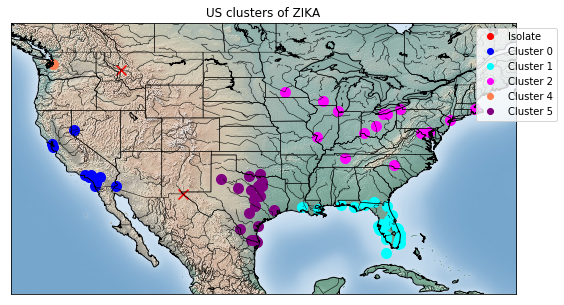

In [41]:
m = draw_cluster_map(df_US_zika,'DBSCAN_cluster_gc','US clusters of ZIKA',True,True,'l',100)

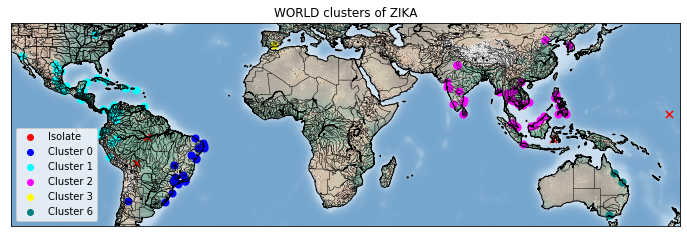

In [42]:
m = draw_cluster_map(df_WORLD_zika,'DBSCAN_cluster_e','WORLD clusters of ZIKA',True,True,'l')

## MAD COW clusters

From https://www.cdc.gov/prions/bse/:
"Bovine Spongiform Encephalopathy (BSE) is a progressive neurological disorder of cattle...that peaked in 
January, 1993."

While this is a disease in cattle and not in humans, there has been 

"strong...evidence...for a causal 
association between 
a new human prion disease called variant Creutzfeldt-Jakob disease (vCJD) that was first reported from the 
United Kingdom in 1996 and the BSE outbreak in cattle."

Some research indicates that outbreaks of BSE (mad cow) can be followed about 10 years later by outbreaks of vCJD.


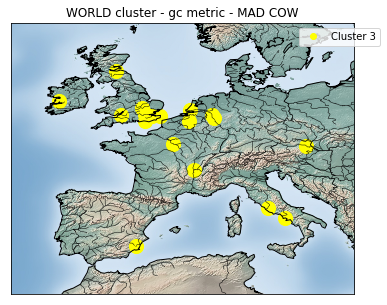

In [43]:
m = draw_cluster_map(df_WORLD_madcow,'DBSCAN_cluster_e','WORLD cluster - gc metric - MAD COW',True,True,'l',200)

# Final exports
Export cleaned, pared-down data so that the final notebook is simple and easy to follow.

In [44]:
df_WORLD_madcow.to_csv('../data-files/s4_world_madcow.csv')
df_US_zika.to_csv('../data-files/s4_us_zika.csv')
df_WORLD_zika.to_csv('../data-files/s4_world_zika.csv')